In [1]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

## Czyszczenie danych

In [55]:
df_raw = pd.read_csv(
    r"data\descriptions\training_data_recznie_poprawione.csv", header=0, sep=";"
)
df_raw = df_raw.reset_index()
df = df_raw.copy()
df.head()

,index,Label,Opis
0,0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [56]:
df["Label"].value_counts()

Label
2    273
0    259
1    235
Name: count, dtype: int64

### Zapisanie opisów małymi literami

In [10]:
df["Opis"] = df["Opis"].str.lower()
df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul. bruzdowej 100d. mieszkanie gotowe do wynajęcia, dostępne od zaraz, częściowo umeblowane (kuchnia, łazienka i przedpokój). wygodne, przestronne, w sypialni duża szafa, ogródek około 40 m2. sypialnia o powierzchni 15 m2 z dużymi oknami i roletami. do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie -1 w cenie 350 zł. komunikacja autobusowa przy placu vogla i ulicy sytej, tam też znajduje się mini galeria, lidl, biedronka, restauracje, punkty usługowe, miejsca spotkań. osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego, tuż za wałem jest wisła, dużo zieleni, miejsc do spacerów, trasa rowerowa, wiślańskie plaże. podana cena jest bez czynszu administracyjnego, który wynosi 950 zł. wymagany najem okazjonalny. zapraszam zobacz wirtualny spacer: https://panoramy.galactica.pl/virgo/423768pośrednik odpowiedzialny zawodowo za wykonanie umowy pośrednictwa:  (licencja

### Usunięcie ukraińskich znaków

In [11]:
ukrainian_desc = '''
2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku
2 окремих будинки на ділянці 1700 кв.м. вул. Beskidzka Rzeszów - 21 житлова кімната, мебльована, склад, два гаражі (30 кв. м та 40 кв. м). Ідеальна нерухомість під компанію, послуги, житло для співробітників. Дуже хороший стан, укомплектований. Додаткова інформація - можлива оренда кожної будівлі окремо
'''

def remove_ukrainian_characters(text):
    
    pattern = "[а-яА-ЯіІїЇєЄ]+"
    return re.sub(pattern, "", text)

remove_ukrainian_characters(ukrainian_desc)

'\n2 wolnostojących domy na działce 1700 m.kw. ul. Beskidzka Rzeszów - 21 pokój mieszkalny, umeblowany, magazyn, Dwa garaży (30 m.kw i 40 m.kw). Idealna nieruchomość dla firmy , usług, mieszkania dla pracowników. Stan bardzo dobry, wyposażony. Dodatkowa informacja - dzwonić jest możliwość wynajmu osobno każdego budynku\n2     1700 .. . Beskidzka Rzeszów - 21  , , ,   (30 .   40 . ).    , ,   .   , .   -     \n'

In [12]:
df["Opis"] = df["Opis"].apply(remove_ukrainian_characters)

### Usunięcie linków, znaków specjalnych, interpunkcji oraz liczb

In [13]:
from string import digits

def remove_special_chars(text):
    if text is not None:
        text = text.replace('www','https://www')
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
        cleaned_text = re.sub(r"[^\w\s]", "", text)
        cleaned_text = ''.join(filter(lambda x: not x.isdigit(), cleaned_text))
        return cleaned_text
    else:
        return None
    

df["Opis"] = df["Opis"].apply(remove_special_chars)

df["Opis"][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul bruzdowej d mieszkanie gotowe do wynajęcia dostępne od zaraz częściowo umeblowane kuchnia łazienka i przedpokój wygodne przestronne w sypialni duża szafa ogródek około  m sypialnia o powierzchni  m z dużymi oknami i roletami do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie  w cenie  zł komunikacja autobusowa przy placu vogla i ulicy sytej tam też znajduje się mini galeria lidl biedronka restauracje punkty usługowe miejsca spotkań osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego tuż za wałem jest wisła dużo zieleni miejsc do spacerów trasa rowerowa wiślańskie plaże podana cena jest bez czynszu administracyjnego który wynosi  zł wymagany najem okazjonalny zapraszam zobacz wirtualny spacer  odpowiedzialny zawodowo za wykonanie umowy pośrednictwa  licencja nr '

### Stemming i lemantyzacja

In [14]:
nlp_pl = spacy.load("pl_core_news_md")

opisy_mieszkan = df["Opis"]

przetworzone_opisy = []
for opis in df["Opis"]:
    doc = nlp_pl(opis)
    przetworzony_opis = " ".join([token.lemma_ for token in doc if not token.is_stop])
    przetworzone_opisy.append(przetworzony_opis)

df["Opis"] = przetworzone_opisy
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Usunięcie pojedyńczych znaków pozwstałych w trakcie czyszczenia tekstu

In [15]:
def remove_single_letters(text):
    return re.sub(r"\b\w\b\s*", "", text)


# Zastosowanie funkcji do kolumny 'opis_mieszkania'
df["Opis"] = df["Opis"].apply(remove_single_letters)
df["Opis"][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Usunięcie polskich znaków

In [16]:
df["Opis"] = df["Opis"].apply(unidecode)
df["Opis"][0]

'wynajac mieszkanie dwupokojowy ogrodek garaz wilanowa zawada ulica bruzdowy mieszkanie gotowy wynajac dostepny zaraz czesciowo umeblowac kuchnia lazienka przedpokoj wygodny przestronny sypialnia duzy szafa ogrodek   metr sypialnia powierzchnia   metr duzy okno rolet mieszkanie przynalezec miejsce parkingowy duzy komorka lokatorsky poziom   cena   zloty komunikacja autobusowy plac vogla ulica syty znajdowac mini galeria lidl biedronka restauracja punkt uslugowy miejsce spotkanie osiedle zamkniety wyjscie wyjazd wal zawadowskiy tuz wal wisly zielen miejsce spacer trasa rowerowy wislanski plaza podac cena czynsz administracyjny wynosic   zloty wymagac najem okazjonalny zapraszac zobaczyc wirtualny spacer   odpowiedzialny zawodowo wykonac umowa posrednictwo   licencja numer'

### Podział na dane treningowe i testowe

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


## Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF
TfidfVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu opisowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w macierzy TF-IDF są obliczane dla każdego słowa w każdym opisie. Wagi odzwierciedlają istotność danego słowa w konkretnym opisie w kontekście całego zbioru opisów.

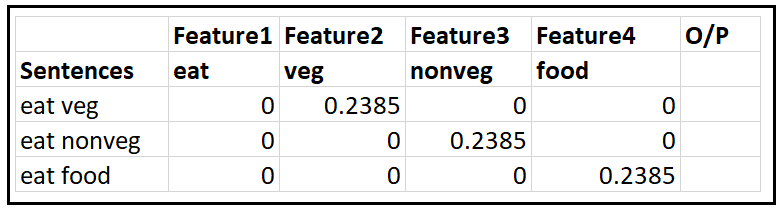

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100) # 80 najczęściej występujących wyrazów
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Zawartość macierzy TF-IDF można podejrzeć w przeglądarce zmiennych

In [131]:
df_tfidf = pd.DataFrame(data=X_train.toarray(), 
                  columns=tfidf.get_feature_names_out())

df_tfidf

,administracyjny,agd,and,aneksem,apartament,apartment,art,balkon,bardzo,budynek,...,woda,wynajęcia,wysłana,za,zapraszam,ze,znajduje,zł,łazienka,łazienki
0,0.000000,0.000000,0.292261,0.000000,0.022335,0.055505,0.012983,0.000000,0.000000,0.010734,...,0.000000,0.000000,0.000000,0.016672,0.009199,0.000000,0.017219,0.000000,0.007681,0.000000
1,0.029988,0.031284,0.499102,0.000000,0.000000,0.043444,0.000000,0.000000,0.028412,0.033607,...,0.030180,0.000000,0.000000,0.026098,0.000000,0.000000,0.026956,0.112410,0.024049,0.024886
2,0.000000,0.154307,0.000000,0.153794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.122914,0.000000,0.128728,0.000000,0.000000,0.132956,0.110891,0.000000,0.122750
3,0.000000,0.000000,0.000000,0.085303,0.191307,0.000000,0.000000,0.000000,0.155457,0.000000,...,0.000000,0.068175,0.082302,0.000000,0.078792,0.000000,0.000000,0.000000,0.000000,0.136168
4,0.156013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158535,0.000000,0.174843,...,0.157011,0.000000,0.156511,0.000000,0.000000,0.000000,0.000000,0.000000,0.125116,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358112,0.127690,0.000000
908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.245532,0.000000,0.000000,0.000000,0.000000,0.000000,0.221514,0.000000,0.000000
909,0.186936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.131446,0.158684,0.137664,0.000000,0.176303,0.142186,0.118588,0.000000,0.131271


### Model maszyny wektorów nośnych

In [132]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.7006578947368421
Dokładność na zbiorze testowym: 0.6140350877192983

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        68
           1       0.69      0.77      0.72        77
           2       0.53      0.40      0.46        83

    accuracy                           0.61       228
   macro avg       0.61      0.62      0.61       228
weighted avg       0.60      0.61      0.60       228



**Opis klas:**
- 0: mieszkanie jest nieumeblowane
- 1: mieszkanie jest umeblowane
- 2: mieszkanie jest częściowo umeblowane

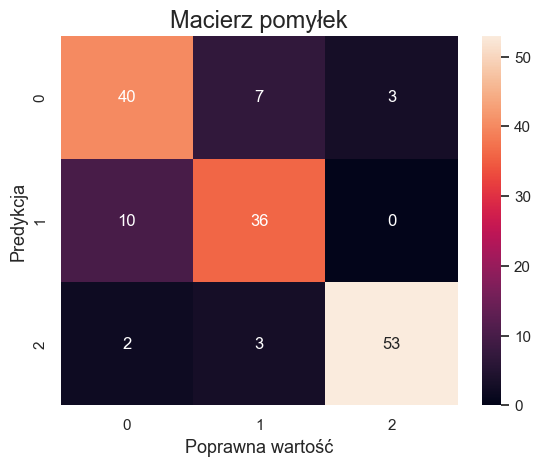

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model drzewa decyzyjnego

In [138]:
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.6677631578947368
Dokładność na zbiorze testowym: 0.6096491228070176

              precision    recall  f1-score   support

           0       0.54      0.91      0.68        68
           1       0.83      0.64      0.72        77
           2       0.52      0.34      0.41        83

    accuracy                           0.61       228
   macro avg       0.63      0.63      0.60       228
weighted avg       0.63      0.61      0.59       228



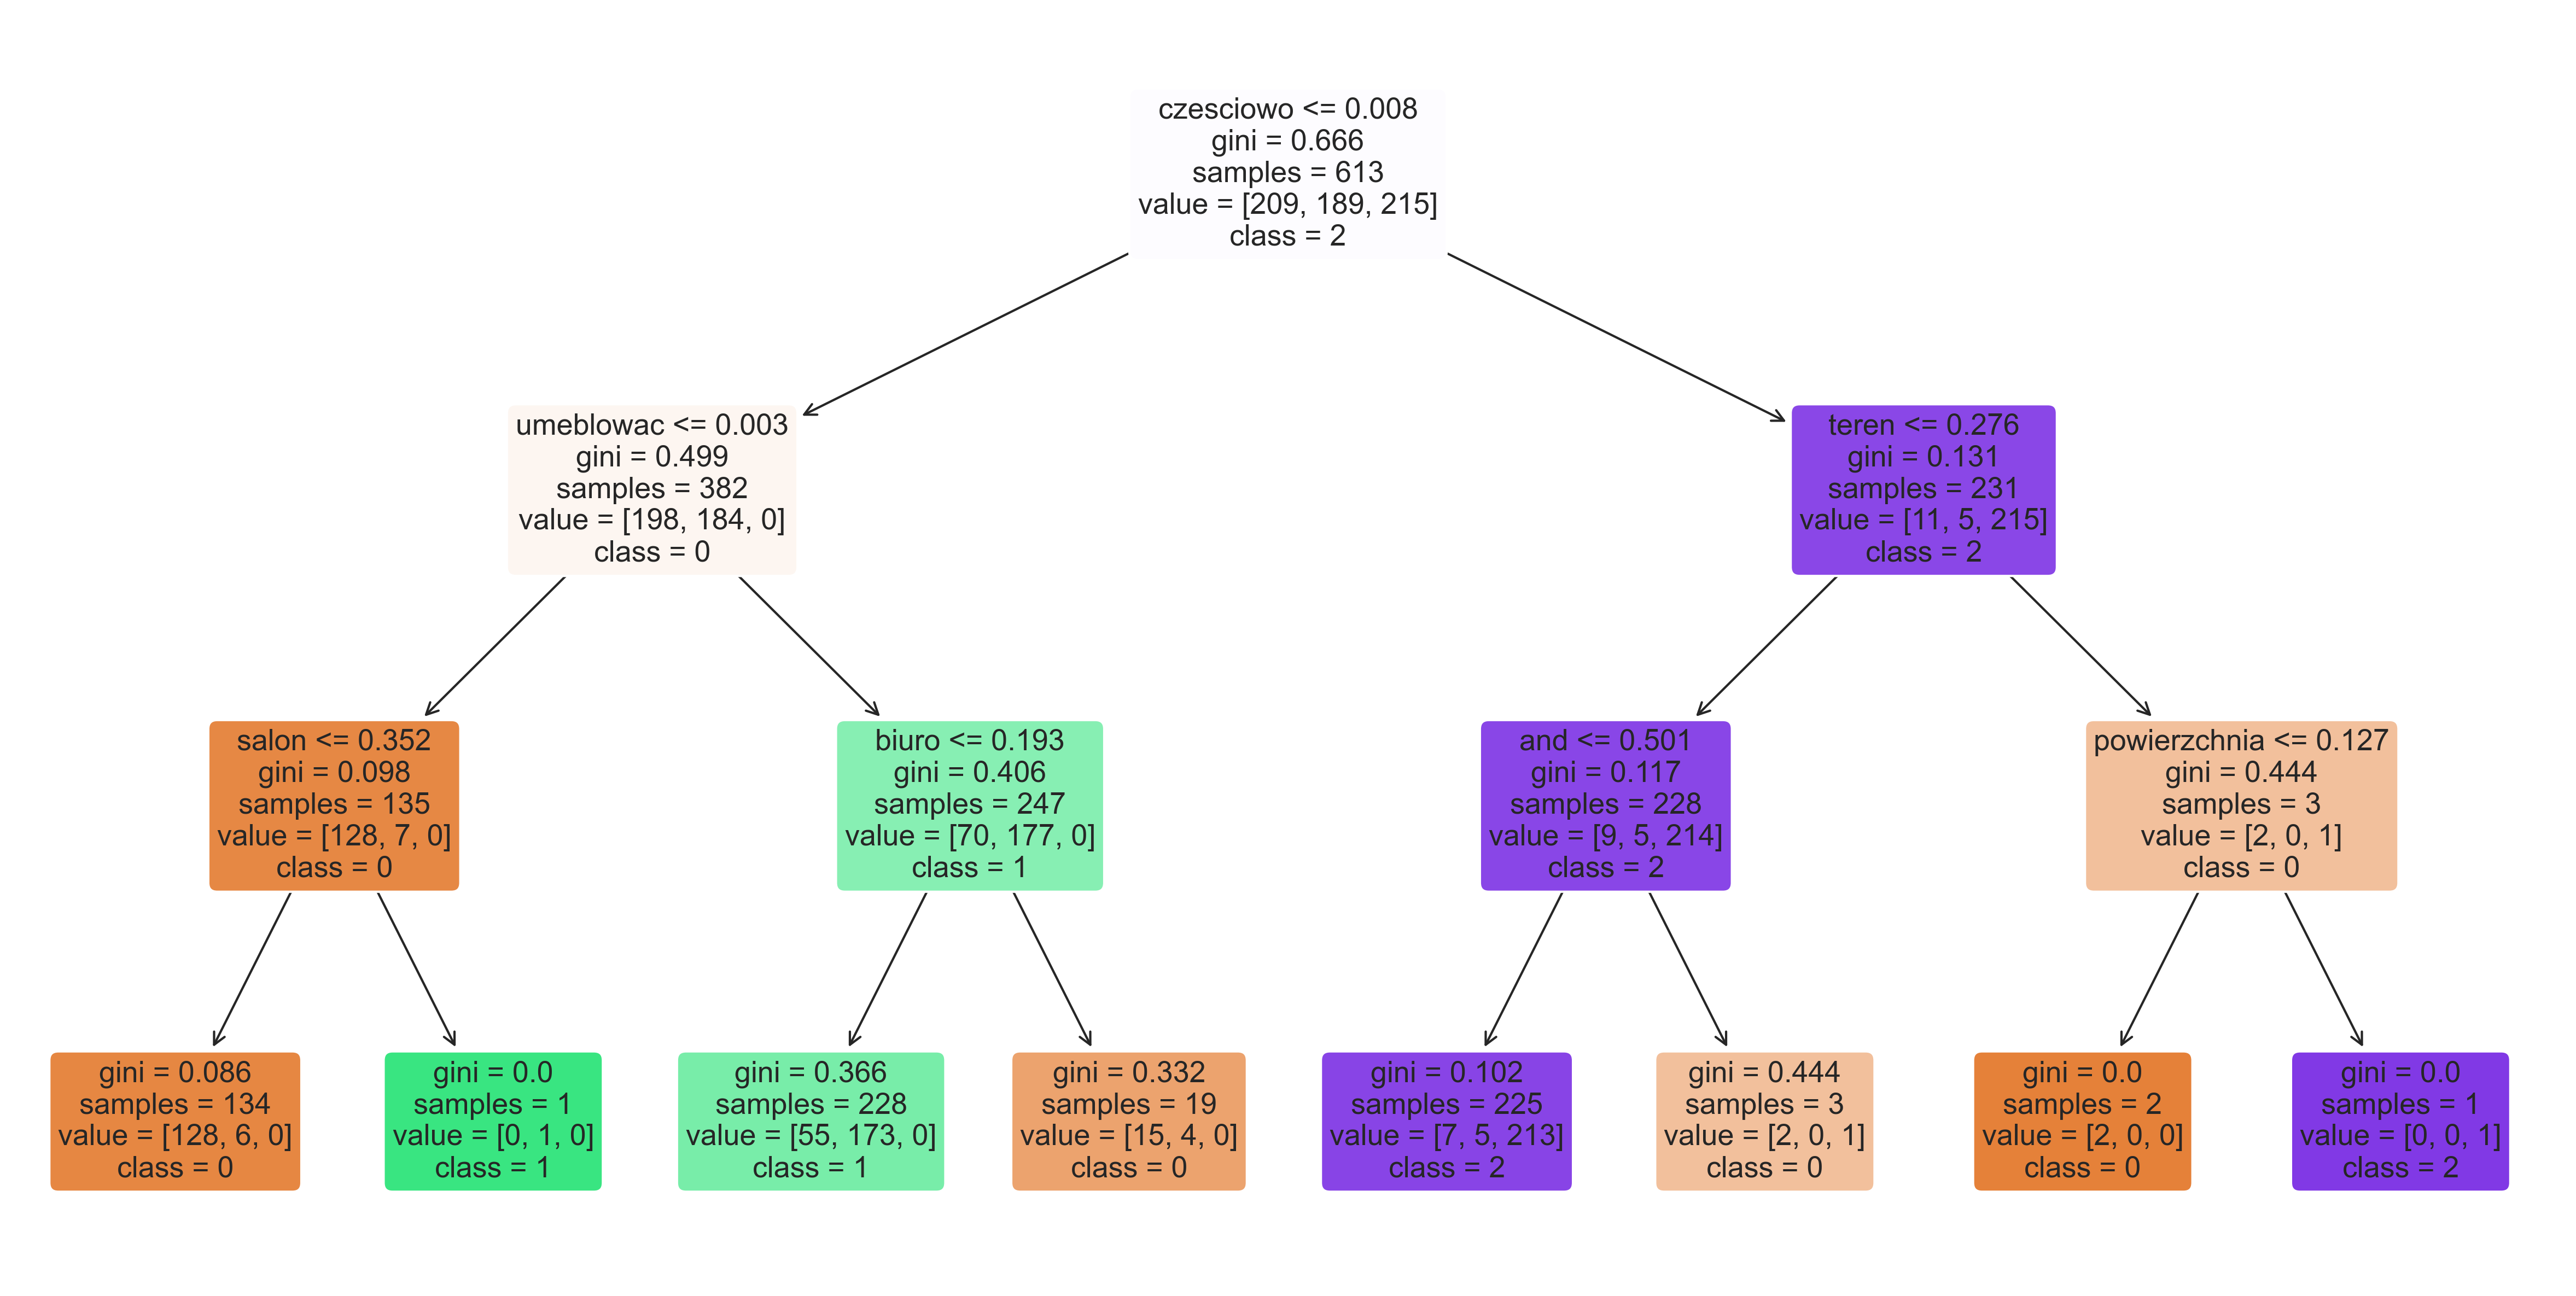

In [21]:
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(dt_clf, feature_names=tfidf.get_feature_names_out().tolist(), class_names=["0", "1", "2"], filled=True, rounded=True)
plt.show()

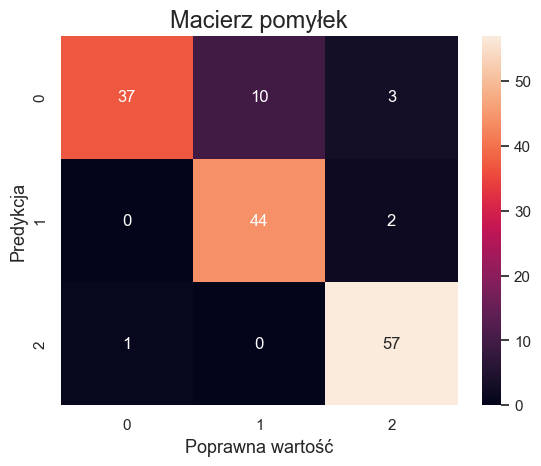

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model regresji logistycznej

In [139]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {logreg_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {logreg_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.6557017543859649
Dokładność na zbiorze testowym: 0.6491228070175439

              precision    recall  f1-score   support

           0       0.66      0.69      0.68        68
           1       0.68      0.82      0.74        77
           2       0.59      0.46      0.52        83

    accuracy                           0.65       228
   macro avg       0.64      0.66      0.64       228
weighted avg       0.64      0.65      0.64       228



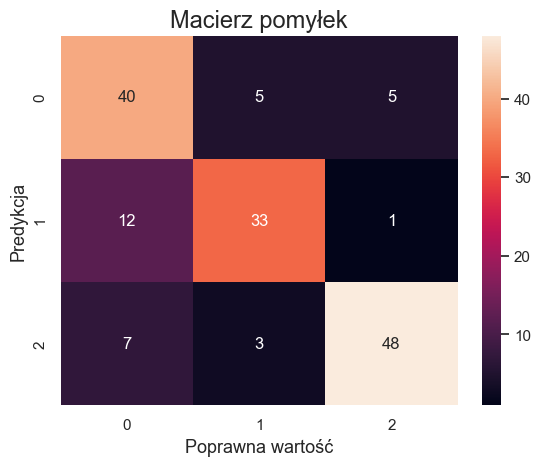

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model lasów losowych

In [140]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(100, max_depth=3, criterion="entropy")
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {rf_clf.score(X_train, y_train)}\n")
print(f"Dokładność na zbiorze testowym: {rf_clf.score(X_test, y_test)}")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.6710526315789473

Dokładność na zbiorze testowym: 0.6622807017543859
              precision    recall  f1-score   support

           0       0.59      0.97      0.74        68
           1       0.73      0.82      0.77        77
           2       0.71      0.27      0.39        83

    accuracy                           0.66       228
   macro avg       0.68      0.68      0.63       228
weighted avg       0.68      0.66      0.62       228



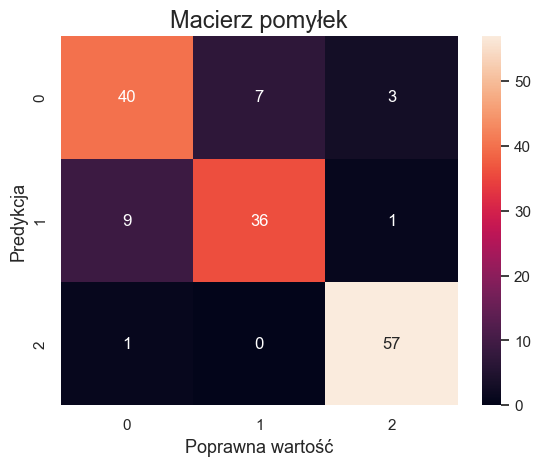

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem funkcji CountVectorizer
CountVectorizer przekształca listę opisów na macierz numeryczną, w której każdy wiersz odpowiada jednemu dokumentowi, a każda kolumna odpowiada jednemu unikalnemu słowu. Wartości w tej macierzy to liczby całkowite reprezentujące ile razy dany termin występuje w danym dokumencie.

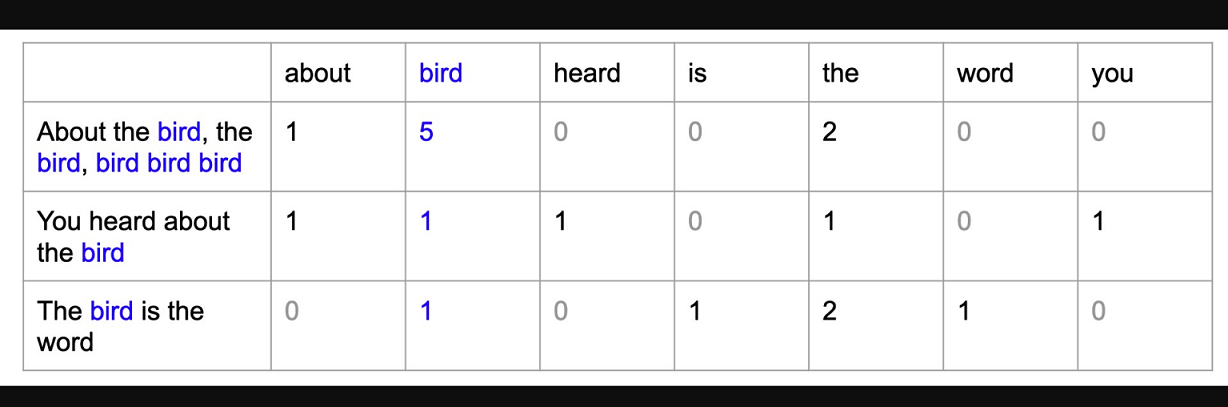

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

count_vec = CountVectorizer(max_features=100)
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

### Pełną zawartość można podejrzeć w przeglądarce zmiennych

In [24]:
df_count_vec = pd.DataFrame(data=X_train.toarray(), 
                  columns=count_vec.get_feature_names_out())

df_count_vec

,administracyjny,and,aneks,apartament,apartment,artykul,balkon,biuro,budynek,cena,...,woda,wynajac,wynajem,wyposazyc,wysoki,zabudowa,zapraszac,zgoda,zloty,znajdowac
0,0,0,1,0,0,1,0,0,0,1,...,0,2,0,1,0,0,0,0,0,0
1,1,0,1,2,0,1,1,2,1,0,...,1,1,0,2,1,0,0,0,1,2
2,0,0,0,0,0,0,2,0,5,2,...,0,0,3,2,1,0,1,0,0,4
3,1,0,0,0,0,0,1,0,2,1,...,2,0,1,1,0,0,0,0,3,0
4,1,0,1,0,0,1,0,2,2,0,...,0,1,0,1,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,0,0,1,0,0,0,1,0,0,2,...,1,1,0,1,1,0,0,0,0,0
609,0,7,1,0,5,0,2,0,3,0,...,0,1,0,1,0,0,0,0,0,2
610,1,0,0,2,0,1,1,0,2,0,...,0,0,0,2,0,1,0,0,0,0
611,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


### Model drzewa decyzyjnego

In [85]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

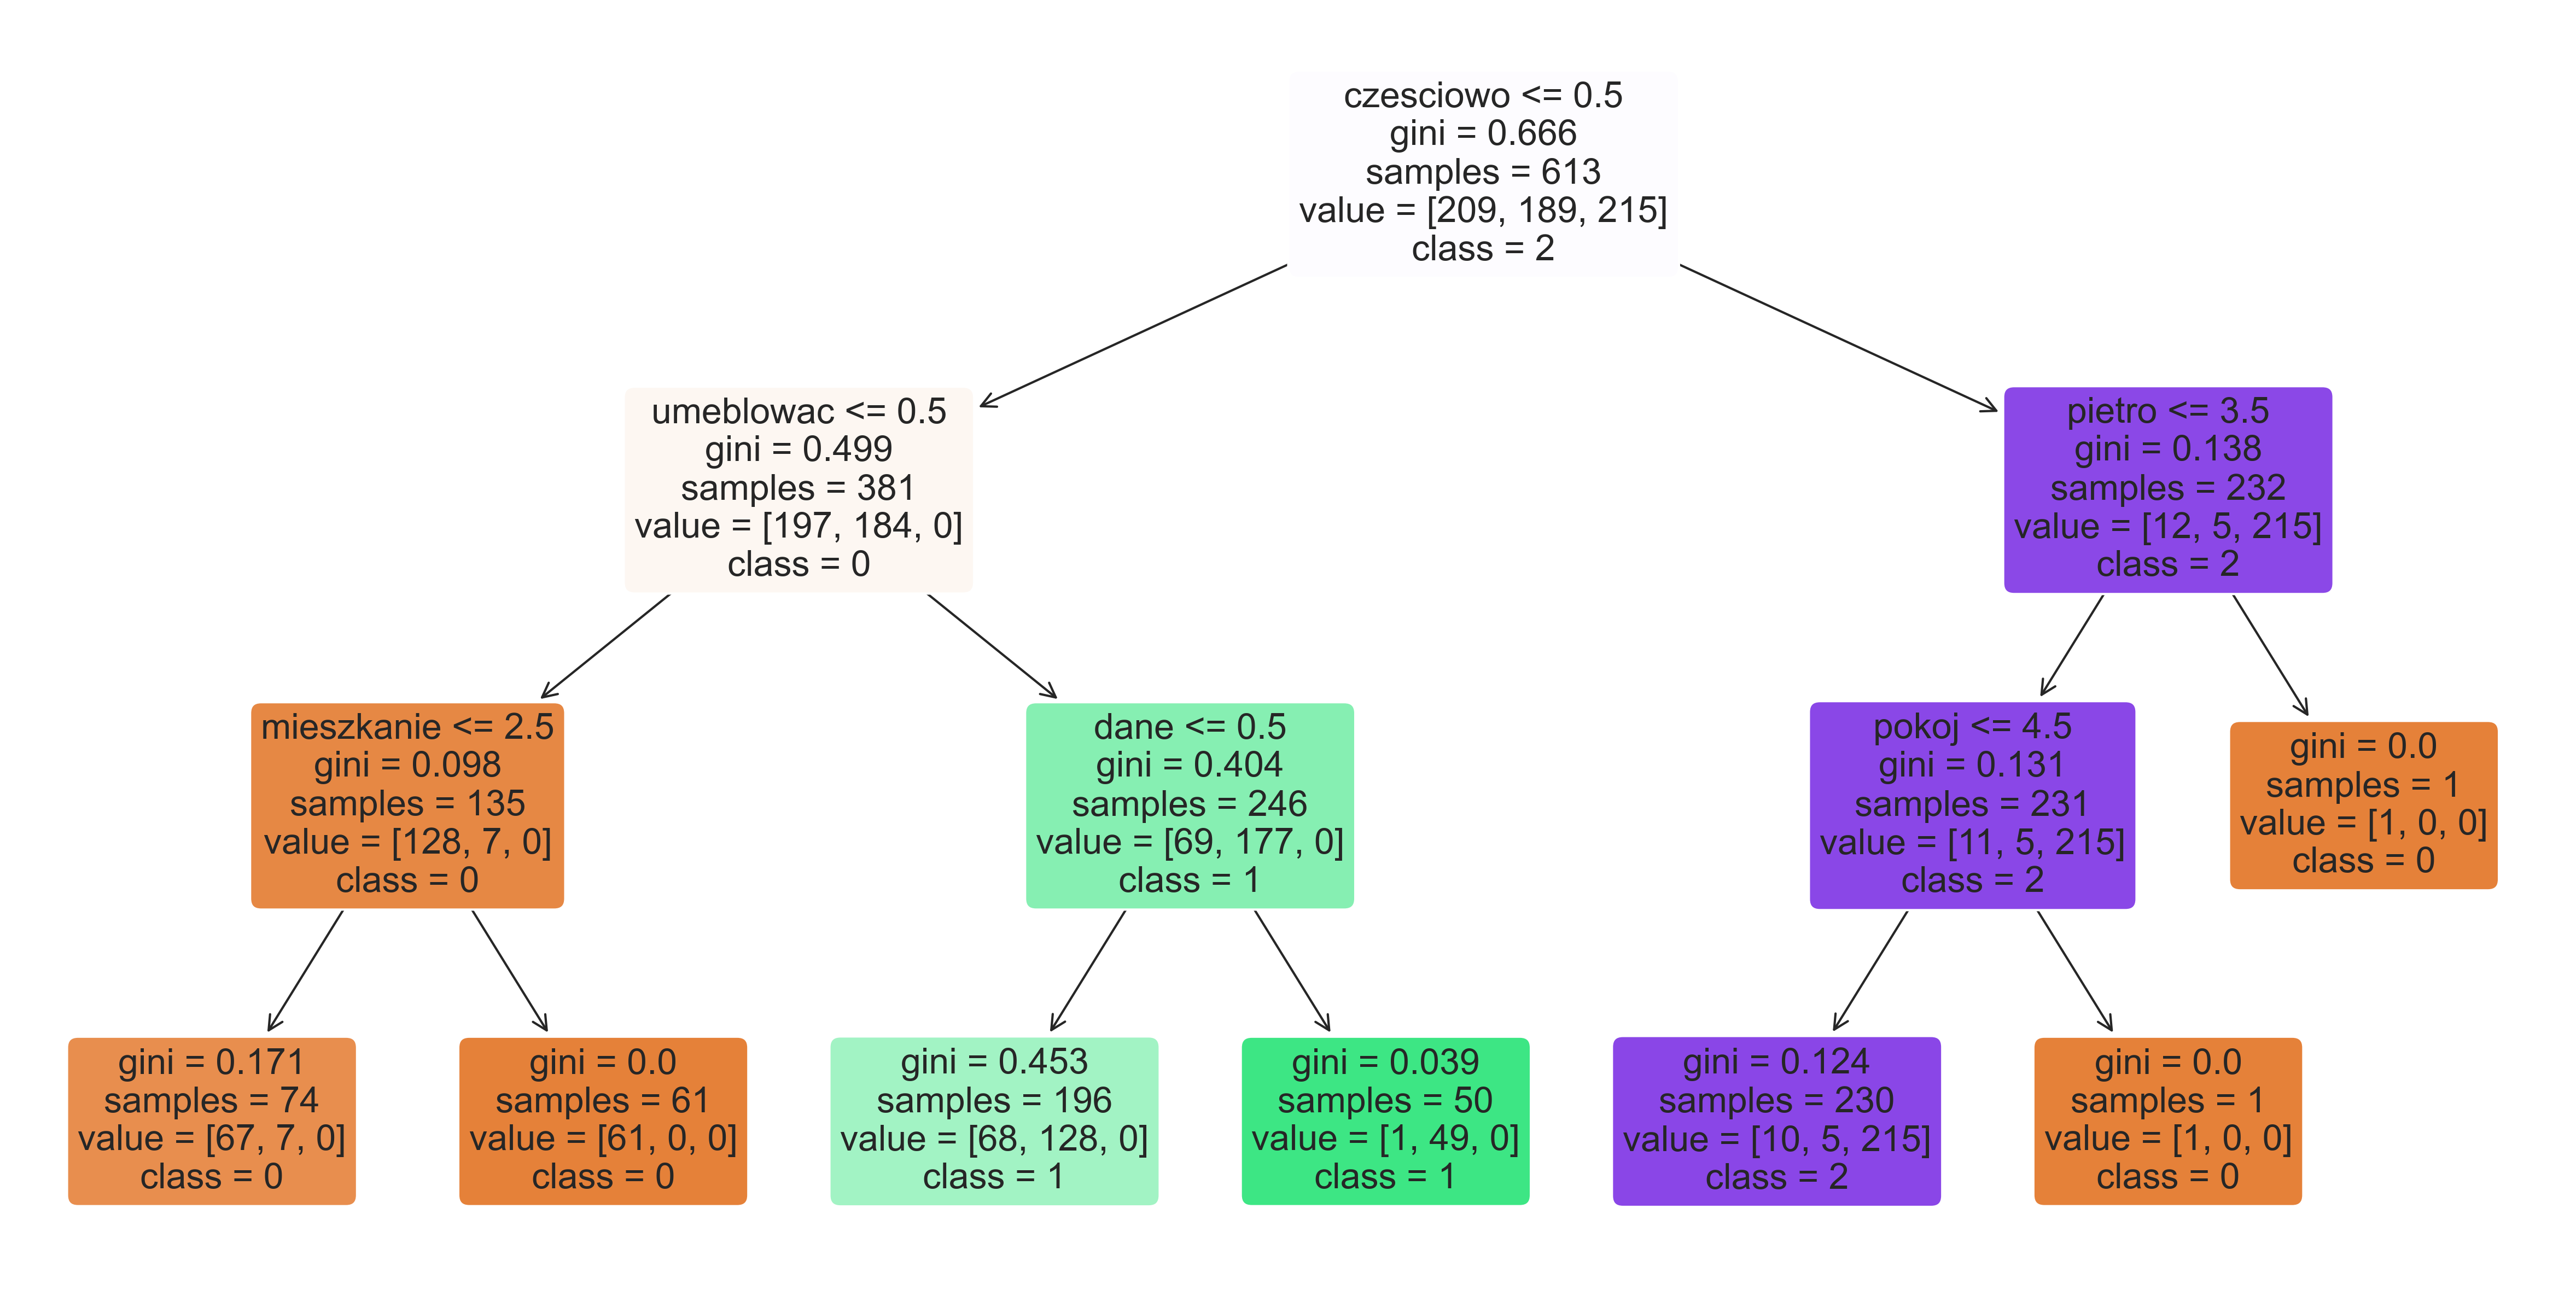

In [28]:
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(dt_clf, feature_names=count_vec.get_feature_names_out().tolist(), class_names=["0", "1", "2"], filled=True, rounded=True)
plt.show()

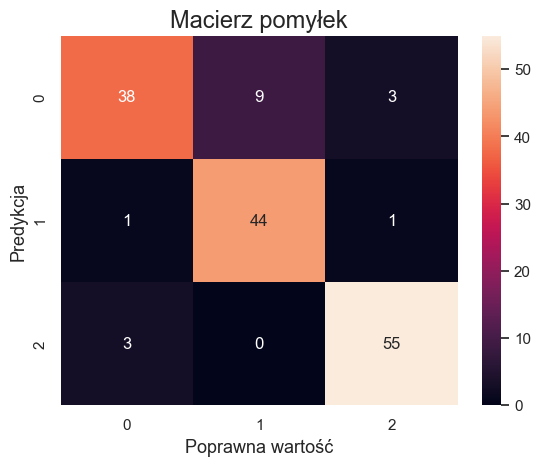

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [35]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9592169657422512
Dokładność na zbiorze testowym: 0.7727272727272727

              precision    recall  f1-score   support

           0       0.63      0.76      0.69        50
           1       0.74      0.70      0.72        46
           2       0.96      0.84      0.90        58

    accuracy                           0.77       154
   macro avg       0.78      0.77      0.77       154
weighted avg       0.79      0.77      0.78       154



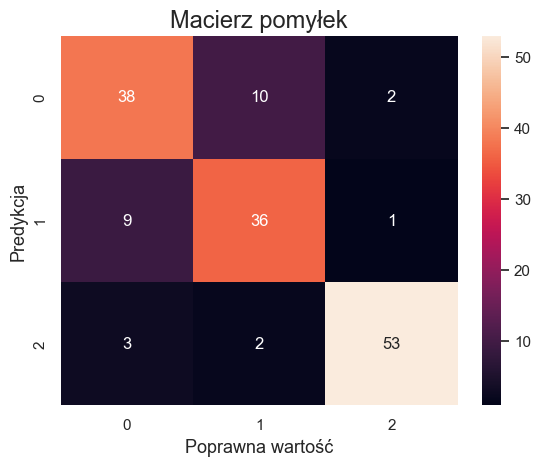

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem Bi-Gramów
W tym przypadku CountVectorizer będzie brał pod uwagę zarówno pojedyncze słowa, jak i pary sąsiadujących słów.

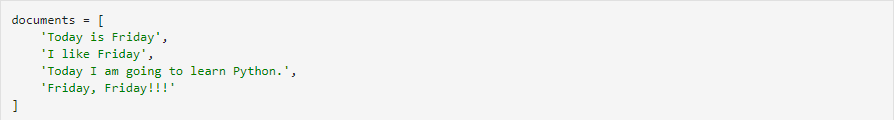
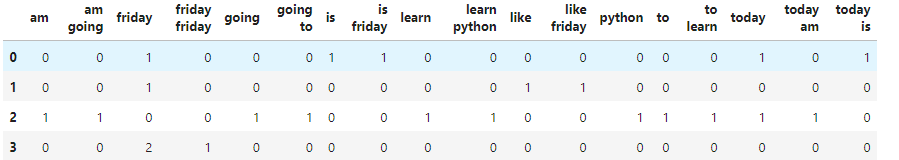

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

bigram = CountVectorizer(ngram_range=(1, 2))
X_train = bigram.fit_transform(X_train)
X_test = bigram.transform(X_test)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Pełną zawartość można podejrzeć w przeglądarce zmiennych

In [41]:
df_bigram_vec = pd.DataFrame(data=X_train.toarray(), 
                  columns=bigram.get_feature_names_out())

df_bigram_vec

,ab,ab krak,abb,abb high,abj,abj nieruchomosc,ablazej,ablazej nota,abonament,abonament gaz,...,zywo bezplatny,zywo kontakt,zywo kontaktzainteresowac,zywo okazja,zywo potencjal,zywo swoj,zywo wygladac,zywo wykonac,zywogreen,zywogreen house
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model drzewa decyzyjnego

In [44]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=10)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {dt_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {dt_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

Dokładność na zbiorze treningowym: 0.9331140350877193
Dokładność na zbiorze testowym: 0.793859649122807



NameError: name 'classification_report' is not defined

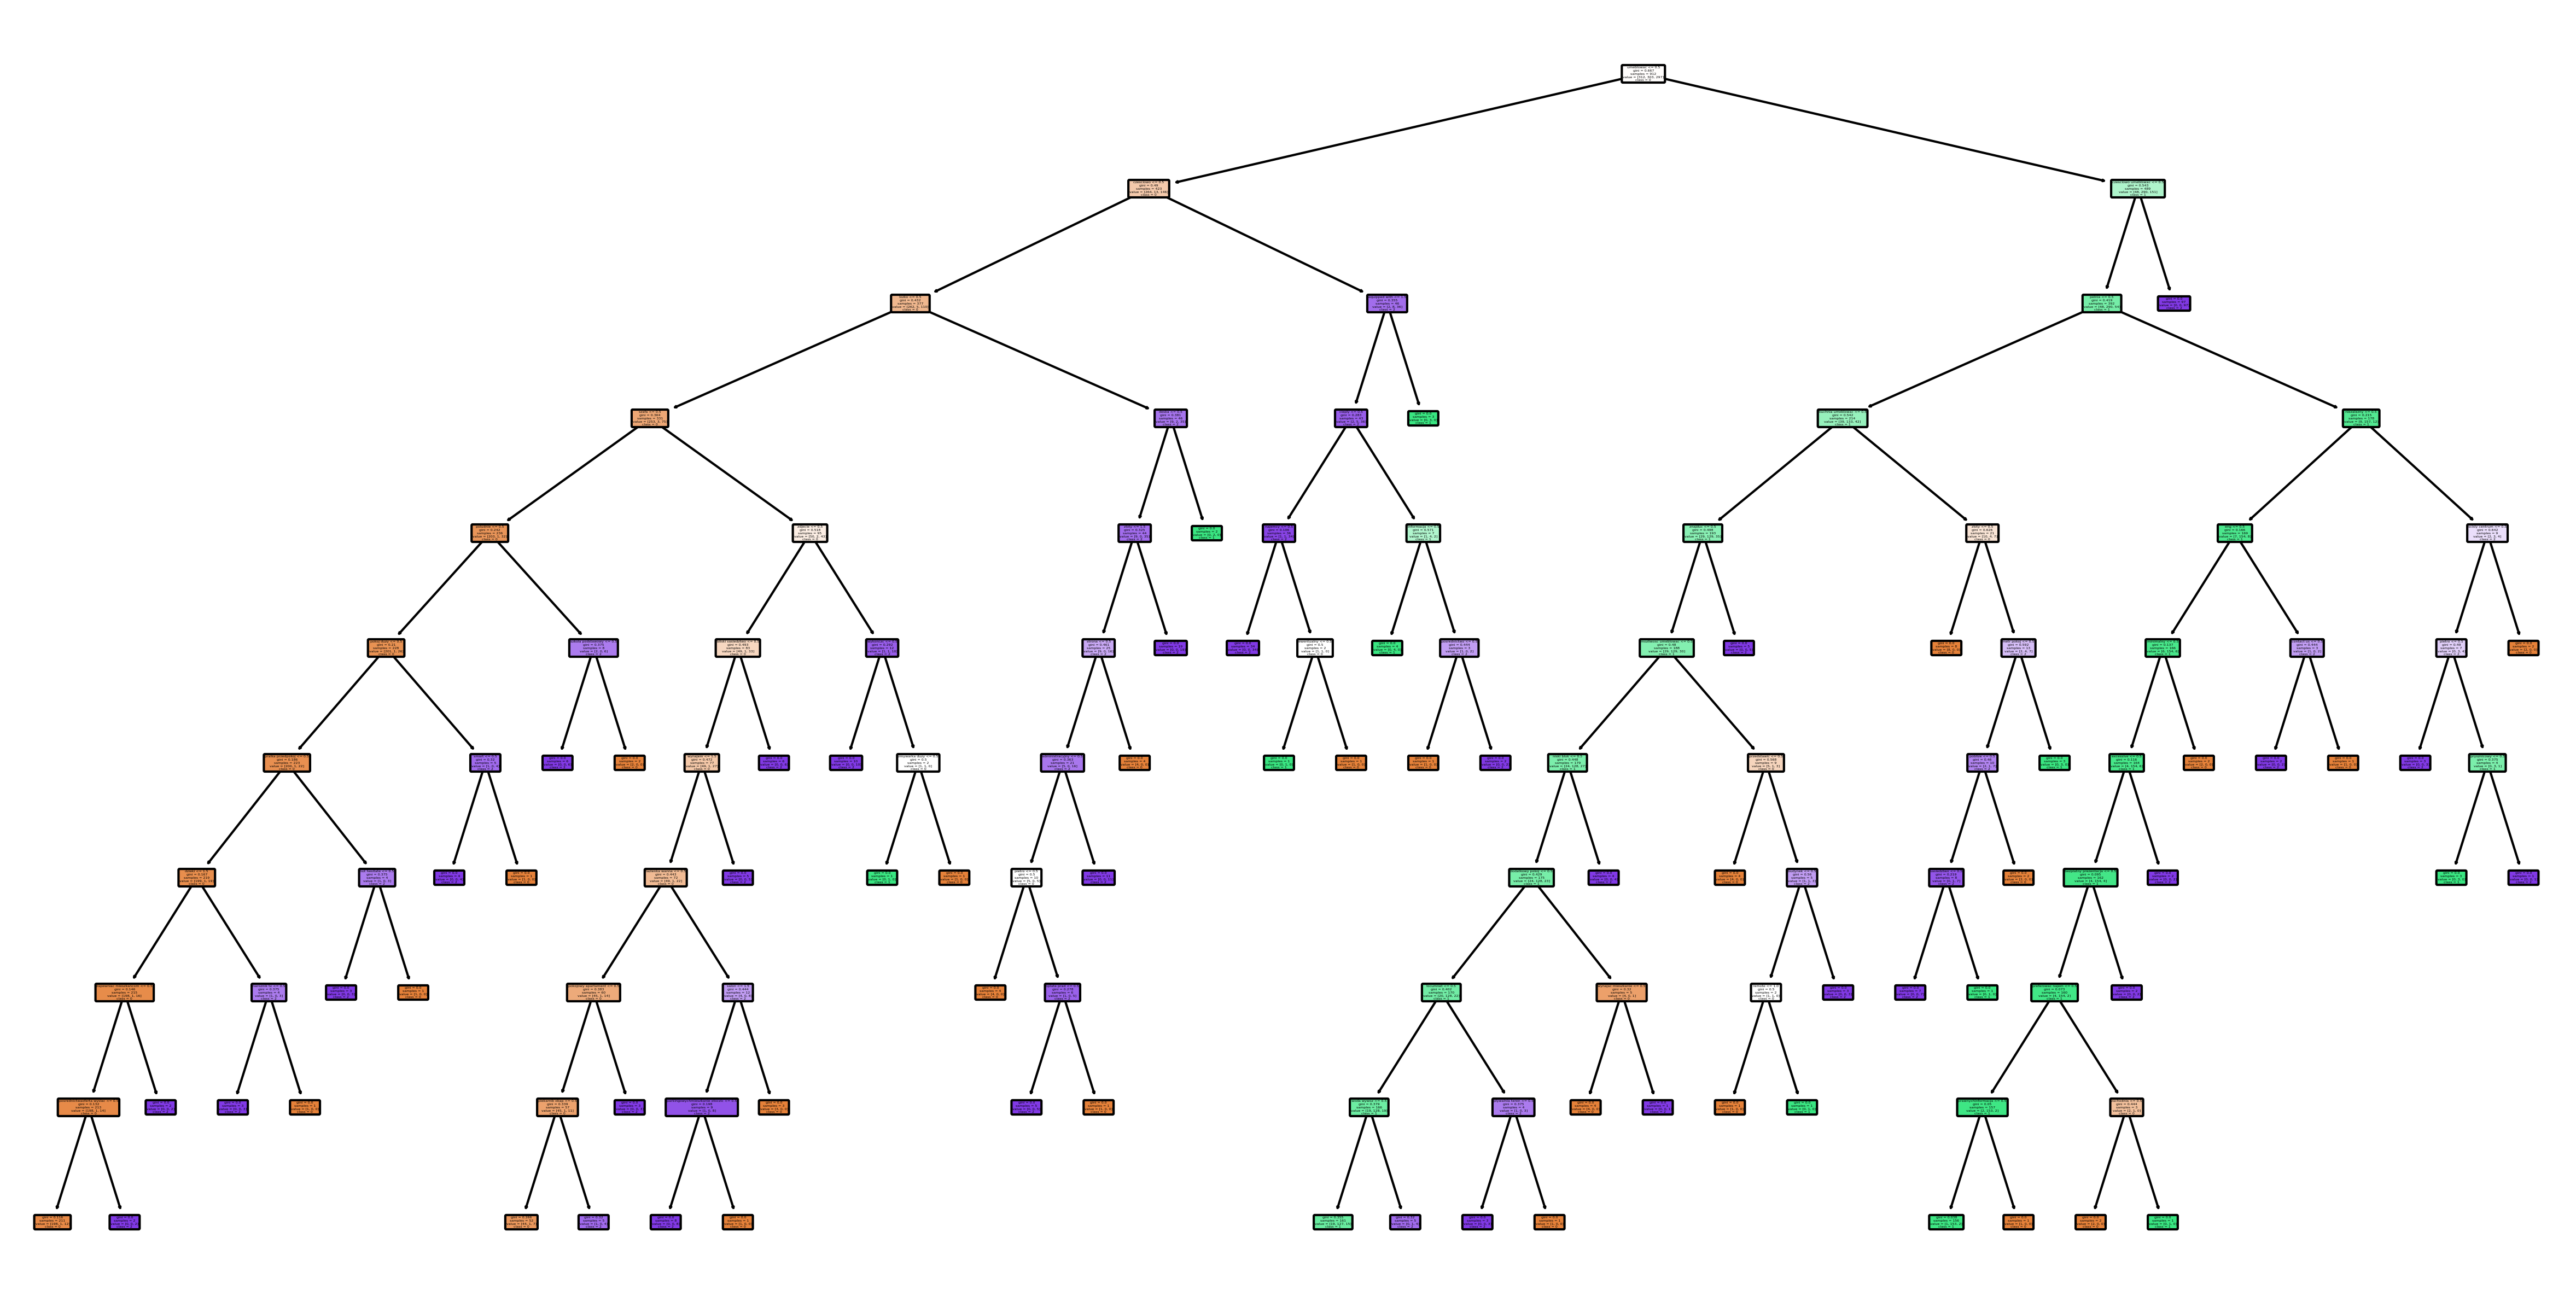

In [30]:
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(dt_clf, feature_names=bigram.get_feature_names_out().tolist(), class_names=["0", "1", "2"], filled=True, rounded=True)
plt.show()

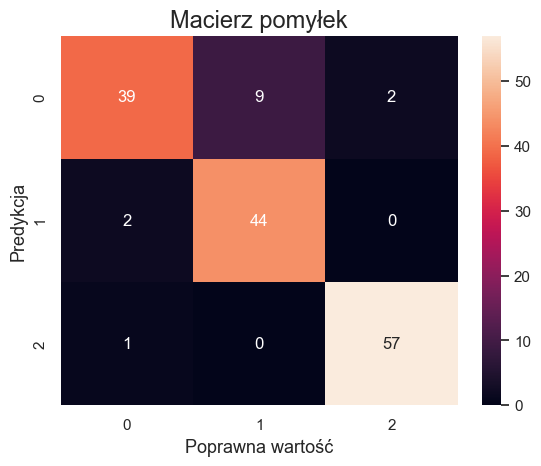

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [82]:
svm_clf = SVC(C=3, kernel="linear", gamma="auto")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print(f"Dokładność na zbiorze treningowym: {svm_clf.score(X_train, y_train)}")
print(f"Dokładność na zbiorze testowym: {svm_clf.score(X_test, y_test)}\n")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

NameError: name 'SVC' is not defined

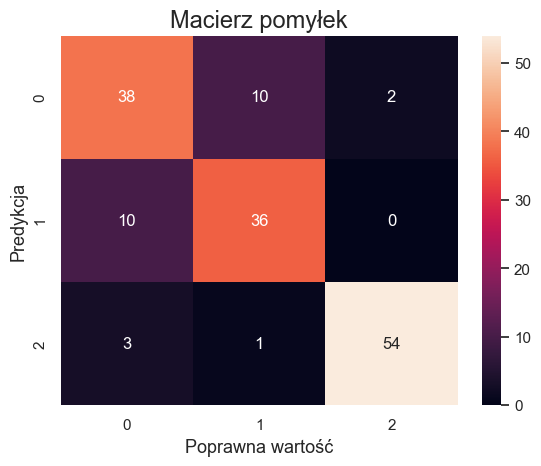

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(
    conf_matrix, annot=True, fmt="g", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2]
)
plt.ylabel("Predykcja", fontsize=13)
plt.xlabel("Poprawna wartość", fontsize=13)
plt.title("Macierz pomyłek", fontsize=17)
plt.show()

In [48]:
def one_sample_predict(model, train_data):
    """ Funkcja przyjmuje wytrenowany model oraz jego dane treningowe w postaci tekstowej. 
    Pobiera od użytkownika pojedyńczy opis przetwarzając go i zwracając predykcję """
    text = input("Podaj opis: ")
    tfidf = TfidfVectorizer(max_features=80)
    _ = tfidf.fit_transform(train_data)
    classes = ["nieumeblowane", "umeblowane", "częściowo umeblowane"]
    text = text.lower()
    cleaned_text = remove_ukrainian_characters(text)
    cleaned_text = remove_special_chars(cleaned_text)

    doc = nlp_pl(cleaned_text)
    cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop])

    cleaned_text = re.sub(r"\b\w\b\s*", "", cleaned_text)
    vectorized_text = tfidf.transform([cleaned_text])

    pred = model.predict(vectorized_text)
    return classes[pred[0]]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Opis"], df["Label"], random_state=42, test_size=0.2, shuffle=True
)

one_sample_predict(svm_clf, X_train)

'częściowo umeblowane'

In [64]:
df_test = pd.read_csv("data\descriptions\dane_do_przetestowania_modelu.csv", header=0, index_col=None)
df_test.head()

,index,Label,Opis
0,0,NaN,mieszkanie znajdowac ulica srebrzynski lod...
1,1,NaN,mieszkanie znajdowac zmodernizowanym rok pie...
2,2,NaN,budynek trzypietrowy oddac uzytkowac wrzesie...
3,3,NaN,wynajac wygodny pokoj wyscig konny sluzewiec k...
4,4,NaN,nowoczesny kawalerka generalny remont nikt m...


In [74]:
df_full = pd.read_csv("data\descriptions\opisy_wszystkie.csv", header=0, index_col=None)
df_full = df_full.reset_index()
df_full.head()

,index,Label,Opis
0,0,NaN,Mieszkania znajdują się przy ulicy Srebrzyńsk...
1,1,NaN,Mieszkania znajdują się zmodernizowanym w 201...
2,2,NaN,Budynek jest trzypiętrowy (oddany do użytkowa...
3,3,NaN,Do wynajęcia wygodne dwa pokoje przy Wyścigach...
4,4,NaN,Nowoczesna kawalerka po generalnym remoncie - ...


In [65]:
vectorized_test = tfidf.transform(df_test["Opis"])

In [75]:
test_prediction = dt_clf.predict(vectorized_test)
df_full['Label'] = test_prediction
df_full.head()

,index,Label,Opis
0,0,0,Mieszkania znajdują się przy ulicy Srebrzyńsk...
1,1,0,Mieszkania znajdują się zmodernizowanym w 201...
2,2,1,Budynek jest trzypiętrowy (oddany do użytkowa...
3,3,0,Do wynajęcia wygodne dwa pokoje przy Wyścigach...
4,4,0,Nowoczesna kawalerka po generalnym remoncie - ...


In [77]:
df_full["Label"].value_counts()

Label
0    6317
1    3180
2     487
Name: count, dtype: int64

In [6]:
df_full.to_csv("data\descriptions\dane_do_sprawdzenia.csv",index=None, header=True)

NameError: name 'df_full' is not defined

In [2]:
df_mat = pd.read_csv(r"C:\Users\wilko\Downloads\3000-6000 - dane_do_sprawdzenia-mateusz (15).csv", header=None)[:2100]
df_mat

,0,1,2
0,3000,1,TL Nieruchomości oferuje do wynajęcia fantasty...
1,3001,1,"TL Nieruchomości oferuje do wynajęcia nowe, pr..."
2,3002,1,TL Nieruchomości oferuje do wynajęcia bardzo ł...
3,3003,1,Oferujemy do wynajęcia mieszkanie w Centrum pr...
4,3004,2,Domino Nieruchomości poleca do wynajęcia 2 po...
...,...,...,...
2095,5095,2,"Do wynajęcia od 1 lipca, kawalerka z ogródkiem..."
2096,5096,2,Biuro Nieruchomości WIZ ESTATES ma przyjemność...
2097,5097,0,Mokotów Górny - ul. Lewicka / 130 m2 / 5pokoi ...
2098,5098,1,REZERWACJA DO 01.08.2023Tobiasz Estate Nieruch...


In [3]:
df_bar = pd.read_excel(r"C:\Users\wilko\Downloads\next1701.xlsx", header=None)[1:1700]
df_bar.head()

,0,1,2
1,13,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
2,18,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
3,43,1,Przedstawiam Państwu ofertę najmu nowego 3-pok...
4,56,1,"Wynajmę bezpośrednio piękne, klimatyczne miesz..."
5,116,2,Do wynajęcia mieszkanie 70m z tarasem o powier...


In [4]:
df_con = pd.concat([df_bar, df_mat], axis=0, ignore_index=True)
df_con

,0,1,2
0,13,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,18,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,43,1,Przedstawiam Państwu ofertę najmu nowego 3-pok...
3,56,1,"Wynajmę bezpośrednio piękne, klimatyczne miesz..."
4,116,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
...,...,...,...
3794,5095,2,"Do wynajęcia od 1 lipca, kawalerka z ogródkiem..."
3795,5096,2,Biuro Nieruchomości WIZ ESTATES ma przyjemność...
3796,5097,0,Mokotów Górny - ul. Lewicka / 130 m2 / 5pokoi ...
3797,5098,1,REZERWACJA DO 01.08.2023Tobiasz Estate Nieruch...


In [5]:
df_con[1].value_counts()

1
1    2504
0     521
2     387
3     387
Name: count, dtype: int64

In [6]:
df_nieumeblowane = df_con[df_con[1] == 0][:380]
df_nieumeblowane

,0,1,2
87,1839,0,Apartament na parterze z ogródkiem położony w ...
94,1966,0,"| Przytulne i widne mieszkanie, po generalnym ..."
307,451,0,UMEBLOWANE MIESZKANIE BLISKO CENTRUM HANDLOWEG...
324,513,0,WOLNE OD WRZEŚNIA 2023Eleganckie dwupokojowe m...
363,607,0,Wynajmę bezpośrednio mieszkanie 2 pokojowe 37m...
...,...,...,...
3354,4655,0,Konkurs na najem lokalu mieszkalnego nr 1 poło...
3355,4656,0,Konkurs na najem lokalu mieszkalnego nr 33 poł...
3357,4658,0,Konkurs na najem lokalu mieszkalnego nr 5 poło...
3358,4659,0,Konkurs na najem lokalu mieszkalnego nr 10 poł...


In [7]:
df_umeblowane = df_con[df_con[1] == 1][:380]
df_umeblowane

,0,1,2
2,43,1,Przedstawiam Państwu ofertę najmu nowego 3-pok...
3,56,1,"Wynajmę bezpośrednio piękne, klimatyczne miesz..."
6,213,1,"► OPIS NIERUCHOMOŚCINa wynajem dwustronne, roz..."
7,220,1,Mieszkanie na skraju Bielan Żoliborza i Bemowa...
12,342,1,Elegancki trzy pokojowy apartament zlokalizowa...
...,...,...,...
516,1046,1,"Przestronne, 3-pokojowe mieszkanie zlokalizowa..."
517,1049,1,Dostępne do wynajmu od 01 września 2023Stylowy...
518,1052,1,BEZ PROWIZJI - WYNAGRODZENIE POŚREDNIKA OPŁACA...
519,1053,1,"OFERTA BEZ PROWIZJI, WYNAGRODZENIE POŚREDNIKA ..."


In [8]:
df_cz = df_con[df_con[1] == 2][:380]
df_cz

,0,1,2
0,13,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,18,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
4,116,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
5,120,2,Na wynajem - jasne i przytulne mieszkanie dwup...
8,245,2,Aston Nieruchomości ma przyjemność zaprezentow...
...,...,...,...
3707,5008,2,Mieszkanie 2-pok | 39 m2 | Balkon | Miejsce pa...
3718,5019,2,Oferta na wynajem mieszkania w miejscowości Cz...
3736,5037,2,Wolne od zaraz! Bez prowizji biura! Polecam na...
3739,5040,2,BEZPIECZNA TRANSAKCJA TYLKO Z LICENCJONOWANYM ...


In [9]:
df = pd.concat([df_cz, df_umeblowane, df_nieumeblowane], ignore_index=True)
df.columns = ["index", "Label", "Opis"]
df

,index,Label,Opis
0,13,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,18,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,116,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,120,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,245,2,Aston Nieruchomości ma przyjemność zaprezentow...
...,...,...,...
1135,4655,0,Konkurs na najem lokalu mieszkalnego nr 1 poło...
1136,4656,0,Konkurs na najem lokalu mieszkalnego nr 33 poł...
1137,4658,0,Konkurs na najem lokalu mieszkalnego nr 5 poło...
1138,4659,0,Konkurs na najem lokalu mieszkalnego nr 10 poł...


In [75]:
df["Label"].value_counts()

Label
2    380
1    380
0    380
Name: count, dtype: int64